#Topic modeling
This code contains the training of a topic model based on news media. 
Two relevant news media are compared based on the topics they write about.
Pre-processing steps are described and explained in the code.
The news media can be found in the column 'netloc'.



! Prior note: I used Google Colab to answer this question.
              This code has been constructed as a learning exercise.

Definition of the goal: compare topic proportions between two news media. 

This coding is guided by: https://jveerbeek.gitlab.io/data-mining/index.html

In [ ]:
#load data
import pickle
import pandas as pd

df = pd.read_pickle("framing.p")
df


,tweet_id,date,user,party,state,chamber,tweet,news_mention,url_reference,netloc,title,description,label
0,1325914751495499776,2020-11-09 21:34:45,SenShelby,R,Alabama,Senator,ICYMI – @BusinessInsider declared #Huntsville ...,businessinsider,https://www.businessinsider.com/personal-finan...,www.businessinsider.com,The 10 best US cities to move to if you want t...,The best US cities to move to if you want to s...,
1,1294021087118987264,2020-08-13 21:20:43,SenShelby,R,Alabama,Senator,Great news! Today @mazda_toyota announced an a...,,https://pressroom.toyota.com/mazda-and-toyota-...,pressroom.toyota.com,Mazda and Toyota Further Commitment to U.S. Ma...,"HUNTSVILLE, Ala., (Aug. 13, 2020) – Today, Maz...",
2,1323340848130609156,2020-11-02 19:06:59,DougJones,D,Alabama,Senator,He’s already quitting on the folks of Alabama ...,,https://apnews.com/article/c73f0dfe8008ebaf85e...,apnews.com,"Tuberville, Jones fight for Senate seat in Ala...","GARDENDALE, Ala. (AP) — U.S. Sen. Doug Jones, ...",
3,1323004075831709698,2020-11-01 20:48:46,DougJones,D,Alabama,Senator,I know you guys are getting bombarded with fun...,,https://secure.actblue.com/donate/djfs-close?r...,secure.actblue.com,I just gave!,Join us! Contribute today.,negiotated
4,1322567531320717314,2020-10-31 15:54:06,DougJones,D,Alabama,Senator,"Well looky here folks, his own players don’t t...",,https://slate.com/culture/2020/10/tommy-tuberv...,slate.com,What Tommy Tuberville’s Former Auburn Players ...,"""All I could think is, why?""",
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30803,1305999044196675584,2020-09-15 22:36:51,Liz_Cheney,R,Wyoming At-Large,U.S. Representative,EXCLUSIVE: Liz Cheney Asks The DOJ To Investig...,,https://dailycaller.com/2020/09/15/liz-cheney-...,dailycaller.com,EXCLUSIVE: Liz Cheney Asks The DOJ To Investig...,Rep. Cheney asked the DOJ to probe whether Rus...,
30804,1301257687049687041,2020-09-02 20:36:23,Liz_Cheney,R,Wyoming At-Large,U.S. Representative,Hairpocrisy!\n#PelosiBlowout \n\nNancy Pelosi ...,,https://www.washingtontimes.com/news/2020/sep/...,www.washingtontimes.com,Nancy Pelosi says she was ‘set up’ by San Fran...,House Speaker Nancy Pelosi said she was “set u...,
30805,1296922209890574337,2020-08-21 21:28:45,Liz_Cheney,R,Wyoming At-Large,U.S. Representative,RT @Kredo0: JUST IN: Congressional Republicans...,,https://freebeacon.com/national-security/congr...,freebeacon.com,Congressional Republicans Praise Trump Admin B...,A delegation of Republicans in the House and S...,
30806,1296082124970180613,2020-08-19 13:50:33,Liz_Cheney,R,Wyoming At-Large,U.S. Representative,Liz Cheney slams John Kerry's DNC remarks: Sur...,,https://www.foxnews.com/politics/liz-cheney-jo...,www.foxnews.com,Liz Cheney slams John Kerry's DNC remarks: Sur...,It is surprising that the Democratic National ...,


In [ ]:
#Install the Gensim package for Google Colab
#We need this to be able to run the LDA model later on
import os   

!pip uninstall gensim
!pip install gensim==3.8.3

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

!python -m spacy download nl_core_news_sm



It’s important to have enough meaningful data. Therefore I value the amount of values for each news media. 


In [ ]:
#news media to compare
#show the news media with the most news articles to compare
nr_post_new_media = df.netloc.value_counts()
print(nr_post_new_media.head())

www.nytimes.com     1508
                    1092
www.politico.com     623
www.cnn.com          602
thehill.com          550
Name: netloc, dtype: int64


One of the top 5 options appeared to be empty/unknown. Therefore I looked at four different news media. 

In [ ]:
#Create a subsets for each of the news media
nytimes = df[(df.netloc=="www.nytimes.com")]
politico = df[(df.netloc=="www.politico.com")]
cnn = df[(df.netloc=="www.cnn.com")]
thehill = df[(df.netloc=="thehill.com")]

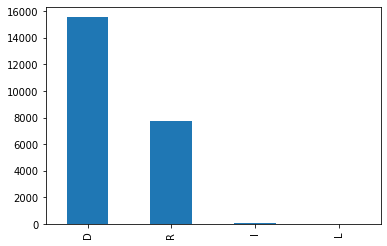

In [ ]:
#distribution of post over political parties
import pandas as pd
df['party'].value_counts().plot(kind='bar')


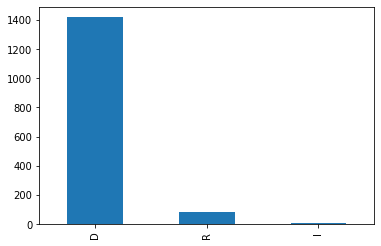

In [ ]:
nytimes['party'].value_counts().plot(kind='bar')

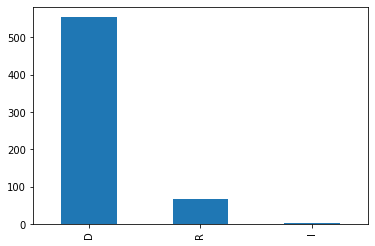

In [ ]:
politico['party'].value_counts().plot(kind='bar')

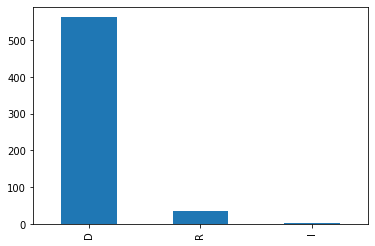

In [ ]:
cnn['party'].value_counts().plot(kind='bar')

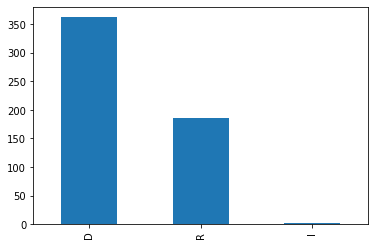

In [ ]:
thehill['party'].value_counts().plot(kind='bar')

#Motivation of the two news media

It’s important to have enough meaningful data. Therefore I value the amount of values for each news media. 

For this analysis I assume that parties refer to news sources that underline their ideals. Therefore I choose the media which is popular in relation to republicans (the hill) and one which is most popular to the democrats(nytimes). I expect that the topics they talk about will be quite similar.



In [ ]:
from tqdm import tqdm_notebook
import spacy
# process the values in the description column of our dataframe
#Otherwise the computer will show that string/series objects do not have a position. 
posts = df.description.values
nlp = spacy.load("en_core_web_sm")
processed_texts = [text for text in tqdm_notebook(nlp.pipe(posts, 
                                              n_process=-1, 
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(posts
                                                   ))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/23448 [00:00<?, ?it/s]

In [ ]:
df['processed_texts'] = processed_texts

In [ ]:
#pre-processing steps
#we can compare the chosen news media nytimes and thehill later on
tokenized_text = [[word.lemma_.lower() for word in processed_texts if word.pos_ == 'VERB' or word.pos == "ADJ" or word.pos_ == "NOUN" or word.pos_ == "PROPN" or word.pos_=="NUM"] for processed_texts in processed_texts]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#Explaination pre-processing sets + parameters:


<table>
  <tr>
    <th>Pre-processing technique</th>
    <th>Include</th>
    <th>Reason</th>
  </tr>
  <tr>
    <td>Tokenization</td>
    <td>Yes</td>
    <td>convert strings to a list of tokens for the computer to understand the text.</td>
  </tr>
  <tr>
    <td>Lemmatization/stemming</td>
    <td>Yes</td>
    <td> lemmatization considers the context and coverts the words to its base while keeping the meaning. </td>
  </tr>
  <tr>
    <td>Lowercasing text</td>
    <td>Yes</td>
    <td> increases word consistency </td>
  </tr>
  <tr>
    <td>Stop word removal</td>
    <td>No</td>
    <td>I choose word type filtering instead, for more control on the type of words that go into the model</td>
  </tr>
  <tr>
    <td>Word type filtering</td>
    <td>Yes</td>
    <td> Included word types: <br> 
    * names (PROPN), include names of politicians
    <br>
    * verbs (VERB) and adjectives (ADJ), emotive words that say a lot about the meaning of the text.
    <br>
    * numbers (NUM), say something about the impact of the text.
    <br>
    * nouns (NOUN), good indicators of topics (words that depend on themselves)
    <br>
    <br>
    Excluded word types would add noise to the model instead of meaning.
    </td>
  </tr>
  <tr>
    <td>Sentence splitting</td>
    <td>No</td>
    <td>I used word tokens</td>
  </tr>
  <tr>
    <td>Flattening</td>
    <td>No</td>
    <td>The LDA model can work with nested lists</td>
  </tr>


In [ ]:
from gensim.corpora import Dictionary

#set a minimum document frequency
MIN_DF = 1 #words need to occur at least once in a document
#set a maximum document frequency
MAX_DF = 0.9 #words have to occur in less then 90 procents of the documents in order to be included

#create a corpus for the LDA model nytimes

#get the vocabulary
dictionary = Dictionary(tokenized_text) 
#fitler the extremes
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]


In [ ]:
#train topic model for nytimes using LDA
#I will choose different numbers of k and then decide based on the highest likelyhood
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'

N_TOPICS = 50 # k
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

In [ ]:
TOPIC = 0
MAX_WORDS = 10
words_50 = lda.show_topic (TOPIC,  topn=MAX_WORDS)
words_50

[('support', 0.03480783176214648),
 ('veteran', 0.025138989605994682),
 ('provide', 0.023205221174764323),
 ('resource', 0.021271452743533963),
 ('crisis', 0.020546289581822575),
 ('click', 0.019579405366207395),
 ('el', 0.019095963258399806),
 ('connect', 0.018129079042784626),
 ('paso', 0.015228426395939087),
 ('call', 0.015228426395939087)]

In [ ]:
#train topic model for nytimes using LDA - k = 100
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'

N_TOPICS = 100 # k
N_ITERATIONS = 1000 

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

In [ ]:
TOPIC = 0
MAX_WORDS = 10
words_100 = lda.show_topic (TOPIC,  topn=MAX_WORDS)
words_100

[('trump', 0.06235912847483095),
 ('president', 0.049586776859504134),
 ('woodward', 0.04658151765589782),
 ('book', 0.04583020285499624),
 ('bob', 0.04357625845229151),
 ('donald', 0.03831705484598046),
 ('accord', 0.03681442524417731),
 ('journalist', 0.03606311044327573),
 ('coronavirus', 0.033809166040571),
 ('week', 0.03305785123966942)]

In [ ]:
#train topic model for nytimes using LDA - k = 200
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'

N_TOPICS = 200 # k
N_ITERATIONS = 1000 # usually 1000 will do

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

In [ ]:
TOPIC = 0
MAX_WORDS = 10
words_200 = lda.show_topic (TOPIC,  topn=MAX_WORDS)
words_200

[('remove', 0.044642857142857144),
 ('proposal', 0.03720238095238095),
 ('market', 0.026785714285714284),
 ('check', 0.023809523809523808),
 ('exist', 0.022321428571428572),
 ('times', 0.022321428571428572),
 ('commissioner', 0.022321428571428572),
 ('york', 0.022321428571428572),
 ('dismiss', 0.020833333333333332),
 ('dementia', 0.020833333333333332)]

In [ ]:
#train topic model for nytimes using LDA - k= 500
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'

N_TOPICS = 500 # k
N_ITERATIONS = 1000 # usually 1000 will do

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

In [ ]:
TOPIC = 0
MAX_WORDS = 10
words_500 = lda.show_topic (TOPIC,  topn=MAX_WORDS)
words_500

[('center', 0.09205020920502092),
 ('medical', 0.05439330543933055),
 ('walter', 0.03138075313807531),
 ('hospital', 0.029288702928870293),
 ('reed', 0.029288702928870293),
 ('national', 0.029288702928870293),
 ('tuesday', 0.02301255230125523),
 ('jennifer', 0.02092050209205021),
 ('visit', 0.02092050209205021),
 ('healthcare', 0.01882845188284519)]

The results between 200 and 500 are not increasing any more. I'm going to try 1000 just to be sure that the likely-hood score does indeed not increase anymore.

In [ ]:
#train topic model for nytimes using LDA - k = 1000
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'

N_TOPICS = 1000 # k
N_ITERATIONS = 1000 # usually 1000 will do

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

In [ ]:
TOPIC = 0
MAX_WORDS = 10
words_1000 = lda.show_topic (TOPIC,  topn=MAX_WORDS)
words_1000

[('coronavirus', 0.1028169014084507),
 ('report', 0.0647887323943662),
 ('million', 0.061971830985915494),
 ('accord', 0.059154929577464786),
 ('crisis', 0.057746478873239436),
 ('republicans', 0.056338028169014086),
 ('pandemic', 0.056338028169014086),
 ('job', 0.056338028169014086),
 ('program', 0.05352112676056338),
 ('house', 0.05352112676056338)]

The numbers did increase and therefore I will go with a 1000 topics.

In [ ]:
#the topic distributions of the highest probability for each topic
#we create a dataframe of the topic distribution (which we will later merge with the original dataframe)
import pandas as pd

transformed_docs = lda.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
topic_distributions.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,...,topic_960,topic_961,topic_962,topic_963,topic_964,topic_965,topic_966,topic_967,topic_968,topic_969,topic_970,topic_971,topic_972,topic_973,topic_974,topic_975,topic_976,topic_977,topic_978,topic_979,topic_980,topic_981,topic_982,topic_983,topic_984,topic_985,topic_986,topic_987,topic_988,topic_989,topic_990,topic_991,topic_992,topic_993,topic_994,topic_995,topic_996,topic_997,topic_998,topic_999
0,0.000122,0.000033,0.000047,0.000079,0.000390,0.000572,0.000033,0.000051,0.000023,0.000041,0.000044,0.000133,0.000004,0.000047,0.000114,0.000030,0.000146,0.000117,0.000189,0.000160,0.000117,0.000048,0.000043,0.000120,0.000105,0.000081,0.000103,0.000477,0.000019,0.000074,0.000447,0.000048,0.000137,0.000025,0.000066,0.000083,0.000758,0.000139,0.000041,0.000033,...,0.000061,0.000040,0.000146,0.000056,0.000026,0.000033,0.000096,0.000066,0.000055,0.000055,0.000028,0.000092,0.000159,0.000059,0.000109,0.000045,0.000281,0.000138,0.000145,0.000077,0.000028,0.000066,0.000094,0.000054,0.000171,0.000768,0.000051,0.000198,0.000156,0.000066,0.000091,0.000094,0.000222,0.000137,0.000266,0.000083,0.000029,0.000148,0.000043,0.000063
1,0.000047,0.000013,0.000018,0.000031,0.000152,0.000223,0.000013,0.000020,0.000009,0.000016,0.000017,0.000052,0.000002,0.000018,0.000045,0.000012,0.000057,0.000046,0.000074,0.000062,0.000046,0.000019,0.000017,0.000047,0.000041,0.000032,0.000040,0.000186,0.000008,0.000029,0.000174,0.000019,0.000053,0.000010,0.000026,0.000032,0.000295,0.000054,0.000016,0.000013,...,0.000024,0.000016,0.000057,0.000022,0.000010,0.000013,0.000038,0.000026,0.000021,0.000021,0.000011,0.000036,0.000062,0.000023,0.000042,0.000018,0.000109,0.000054,0.000056,0.000030,0.000011,0.000026,0.000037,0.000021,0.000067,0.000299,0.000020,0.000077,0.000061,0.000026,0.000035,0.000037,0.000087,0.000053,0.000103,0.000032,0.000011,0.000058,0.000017,0.000025
2,0.000076,0.000021,0.000029,0.000049,0.000244,0.000358,0.000021,0.000032,0.000015,0.000026,0.000028,0.000083,0.000003,0.000029,0.000072,0.000019,0.000092,0.000073,0.000119,0.000100,0.000073,0.000030,0.000027,0.000075,0.000066,0.000051,0.000065,0.000299,0.000012,0.000047,0.000280,0.000030,0.000086,0.000016,0.000041,0.000052,0.000475,0.000087,0.000026,0.000021,...,0.000038,0.000025,0.000092,0.000035,0.000016,0.000021,0.000060,0.000041,0.000035,0.000035,0.000017,0.000058,0.000099,0.000037,0.000068,0.000028,0.000176,0.000086,0.000091,0.000048,0.000017,0.000041,0.000059,0.000034,0.000107,0.140707,0.000032,0.000124,0.000098,0.000041,0.000057,0.000059,0.000139,0.000086,0.000166,0.000052,0.000018,0.000092,0.000027,0.000040
3,0.000370,0.000101,0.000143,0.000240,0.001190,0.001742,0.000101,0.000155,0.000071,0.000126,0.000134,0.000404,0.000013,0.000143,0.000349,0.000092,0.000446,0.000357,0.000577,0.000488,0.000357,0.000147,0.000130,0.000366,0.000320,0.000248,0.000315,0.001454,0.000059,0.000227,0.001362,0.000147,0.000417,0.000076,0.000202,0.000252,0.002310,0.000425,0.000126,0.000101,...,0.000185,0.000122,0.000446,0.000172,0.000080,0.000101,0.000294,0.000202,0.000168,0.000168,0.000084,0.000282,0.000484,0.000181,0.000332,0.000139,0.000856,0.000420,0.000442,0.000235,0.000084,0.000202,0.000286,0.000164,0.000522,0.002340,0.000155,0.000602,0.000475,0.000202,0.000277,0.000286,0.683434,0.000416,0.000810,0.000252,0.000088,0.000450,0.000130,0.000193
4,0.000480,0.000130,0.000185,0.000310,0.001540,0.002256,0.000131,0.000201,0.000092,0.000163,0.000174,0.000523,0.000016,0.000185,0.000452,0.000120,0.000577,0.000462,0.000747,0.000632,0.000463,0.000190,0.000169,0.000474,0.000414,0.000321,0.000408,0.001882,0.000076,0.000294,0.001763,0.000190,0.000539,0.000098,0.000261,0.000326,0.002991,0.0005

In [ ]:
#!pip install pandas==1.3.1
#!pip install pandas --upgrade

In [ ]:
#merge the topic distribution with the original dataframe
joined_topic_dist = df.reset_index().join(topic_distributions)
joined_topic_dist.head()

#create a subset
joined_topic_dist = joined_topic_dist[(joined_topic_dist.netloc=='www.nytimes.com') | (joined_topic_dist.netloc=='thehill.com')]
#create a mask to be able to select all topic columns and the netlock column
#I need this to be able to group on netloc
mask = joined_topic_dist.columns.str.contains('topic') | (joined_topic_dist.columns == 'netloc')
joined_topic_dist = joined_topic_dist.loc[:, mask].head()

#Compare groups
grouped_by_media = joined_topic_dist.groupby('netloc').mean()
grouped_by_media.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,...,topic_960,topic_961,topic_962,topic_963,topic_964,topic_965,topic_966,topic_967,topic_968,topic_969,topic_970,topic_971,topic_972,topic_973,topic_974,topic_975,topic_976,topic_977,topic_978,topic_979,topic_980,topic_981,topic_982,topic_983,topic_984,topic_985,topic_986,topic_987,topic_988,topic_989,topic_990,topic_991,topic_992,topic_993,topic_994,topic_995,topic_996,topic_997,topic_998,topic_999
netloc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
thehill.com,0.000119,0.000032,0.000046,0.000077,0.000383,0.000561,0.000032,0.000050,0.000023,0.000041,0.000043,0.000130,0.000004,0.000046,0.000112,0.000030,0.000144,0.000115,0.000186,0.000157,0.000115,0.000047,0.000042,0.000118,0.000103,0.00008,0.000102,0.000468,0.000019,0.000073,0.000439,0.000047,0.000134,0.000024,0.000065,0.000081,0.000744,0.000137,0.000041,0.000032,...,0.000060,0.000039,0.000144,0.000055,0.000026,0.000032,0.000095,0.000065,0.000054,0.000054,0.000027,0.000091,0.000156,0.000058,0.000107,0.000045,0.000276,0.000135,0.000142,0.000076,0.000027,0.000065,0.000092,0.000053,0.000168,0.000754,0.000050,0.000194,0.000153,0.000065,0.000089,0.000092,0.000218,0.000134,0.000261,0.000081,0.000028,0.000145,0.000042,0.000062
www.nytimes.com,0.000150,0.000041,0.000058,0.000097,0.000481,0.000704,0.000041,0.000063,0.000029,0.000051,0.000054,0.000163,0.000005,0.000058,0.000141,0.000037,0.000180,0.000144,0.000233,0.000197,0.000144,0.000059,0.000053,0.000148,0.000129,0.00010,0.000127,0.000588,0.000024,0.000092,0.000550,0.000059,0.000168,0.000031,0.000082,0.000102,0.000934,0.000172,0.000051,0.000041,...,0.000075,0.000049,0.000180,0.000070,0.000032,0.000041,0.000119,0.000082,0.000068,0.000068,0.000034,0.000114,0.000196,0.000073,0.000134,0.000056,0.000346,0.000170,0.000179,0.000095,0.000034,0.000081,0.000116,0.000066,0.000211,0.000946,0.000063,0.000243,0.000192,0.000082,0.000112,0.000116,0.000274,0.000168,0.000327,0.000102,0.000036,0.000182,0.000053,0.000078


In [ ]:
#I'm going to measure the distance between the two rows using a distance metrics
#I've chosen the cosine similarity distance (source code: https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists)
from scipy import spatial

newyorktimes =  grouped_by_media.iloc[0,:]
thehill = grouped_by_media.iloc[1,:]
result = 1 - spatial.distance.cosine(newyorktimes, thehill)
result

0.002550414840750248

#Explaination results 

Interpretation cosine distance: 
The cosine distance metric measures how similar two vectors are. It looks at the angle between two vectors, to find in what degree they are pointing in the same direction. From word vectors we know that the closer they are together, the more similar they are. A higher outcome therefore means that the overall topics are more alike. The output of a cosine similarity lays between 0 and 1. A score of 0.003 means that the topics scores are on average not very alike. This rejects my earlier hypothesis saying that the topics would be quite similar. (source: https://www-sciencedirect-com.proxy.library.uu.nl/topics/computer-science/cosine-similarity)

Discussion:<br>
In this case study we looked at the average over the different descriptions of news media within tweets of politicians. Note that the amount of messages from the newyorktimes (1508) is almost three times as much as those from the hill (550). Therefore the topics from the hill have a higher weight (more impact) on the results than those from the newyorktimes. It's also possible that papers use different words to relate to the same topic. This would underline my earlier hypothesis.

Parameter tuning: <br>
Another thing I would like to discuss is parameter tuning. I was required to predefine the number of topics. If the number is too small - topics tend to be more general. If the number is too large - topics will be overlapping with eachother. I choose 1000 topics. I also had to decide on the maximum amount of times the words had to occur document. I choose 90 percent. These setting might bias the cosine score. This means that the true similarity between topics might be higher or lower then the score shown in this case study. 

Pre-processing: <br>
I could also have made a different choice when it comes to pre-processing. For example, extra noice reduction within words of the text.


